#### E01
##### Tune the hyperparameters of the training to beat my best validation loss of 2.2 (I tried going below 2.1)

In [25]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [27]:
# conversions
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [28]:
# build the dataset given words and context length
def build_dataset(words, block_size):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for character in word + '.':
            index = stoi[character]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [29]:
# divide into training set (80%), validation/dev set (10%) and test set (10%)
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

context_length = 3
X_train, Y_train = build_dataset(words[:n1], context_length)
X_dev, Y_dev = build_dataset(words[n1:n2], context_length)
X_test, Y_test = build_dataset(words[n2:], context_length)
X_train[:5], Y_train[:5]

(tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([25, 21,  8,  5, 14]))

In [100]:
g = torch.Generator().manual_seed(2147483647)
# dim-dimensional vector space for letters
dim = 24
neuron_num = 512
C = torch.randn((27, dim), generator=g)
# first layer that is hidden
weights1 = torch.randn((dim * context_length, neuron_num), generator=g)
bias1 = torch.randn(neuron_num, generator=g)
# output layer
weights2 = torch.randn((neuron_num, 27), generator=g)
bias2 = torch.randn(27, generator=g)
# all parametters
parameters = [C, weights1, bias1, weights2, bias2]
sum(p.nelement() for p in parameters)

51875

In [101]:
# turning gradient on
for p in parameters:
    p.requires_grad = True

In [102]:
steps = []
log_loss = [] 

In [103]:
for i in range(200000):
    # getting minibatch
    index = torch.randint(0, X_train.shape[0], (256,)) # increased batch size to 256

    # forward pass
    embedings = C[X_train[index]]              
    hidden_layer = torch.tanh(embedings.view(-1, dim * context_length) @ weights1 + bias1)
    logits = hidden_layer @ weights2 + bias2    
    loss = F.cross_entropy(logits, Y_train[index])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= learning_rate * p.grad

    # track log-loss
    steps.append(i)
    log_loss.append(loss.log10().item())
    
    if i % 10000 == 0:
        print(i, loss.item())

0 43.65504837036133
10000 2.803736448287964
20000 2.4207653999328613
30000 2.1950294971466064
40000 1.9529170989990234
50000 2.0166215896606445
60000 2.075808525085449
70000 2.1144537925720215
80000 2.0882649421691895
90000 2.02705454826355
100000 2.0420238971710205
110000 2.0569469928741455
120000 1.951102375984192
130000 1.783360242843628
140000 1.9102058410644531
150000 1.9121332168579102
160000 1.9894870519638062
170000 1.860229253768921
180000 1.8974263668060303
190000 1.991809606552124


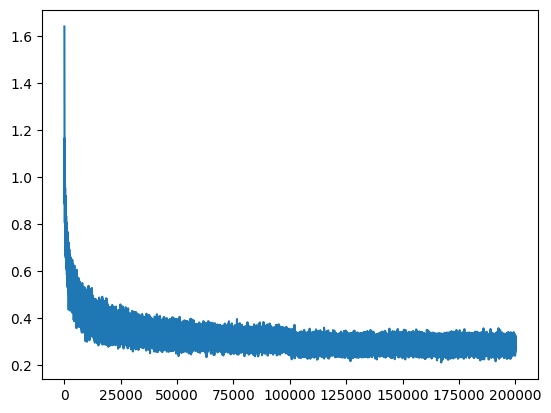

In [104]:
plt.plot(steps, log_loss)

In [105]:
# loss on a whole training set
embedings = C[X_train]             
hidden_layer = torch.tanh(embedings.view(-1, dim * context_length) @ weights1 + bias1)
logits = hidden_layer @ weights2 + bias2    
loss = F.cross_entropy(logits, Y_train)
loss

tensor(1.9410, grad_fn=<NllLossBackward0>)

In [106]:
# loss on a dev set
embedings = C[X_dev]             
hidden_layer = torch.tanh(embedings.view(-1, dim * context_length) @ weights1 + bias1)
logits = hidden_layer @ weights2 + bias2    
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.2372, grad_fn=<NllLossBackward0>)

batch size: 256 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 8 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 256 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 2.1345 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.1611 <br>
batch size: 256 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 12 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 256 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 2.0985 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.1451 <br>
batch size: 256 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 12 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 384 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 2.0765 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.1248 <br>
batch size: 256 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 12 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 512 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 2.0548 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.1325 <br>
batch size: 256 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 16 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 512 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 1.9672 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.2057 <br>
batch size: 256 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 24 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 512 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 1.9410 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.2372

In [69]:
# sample from the model
g =torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * context_length                                         
    while True:
        embedings = C[torch.tensor([context])]                             
        hidden_layer = torch.tanh(embedings.view(1, -1) @ weights1 + bias1)       
        logits = hidden_layer @ weights2 + bias2                            
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        out.append(index)
        if index == 0:
            break
    
    print(''.join(itos[i] for i in out))

celia.
mouhkira.
carity.
kell.
ima.
taine.
kaylyn.
tar.
samiyah.
javer.
gotti.
moriellah.
jacobeda.
kaley.
maside.
eniavion.
ryon.
pristin.
bron.
las.


#### E02 
##### I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

##### E02 (1)

In [96]:
# divide into training set (80%), validation/dev set (10%) and test set (10%)
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

context_length_2 = 3
X_train_2, Y_train_2 = build_dataset(words[:n1], context_length_2)
X_dev_2, Y_dev_2 = build_dataset(words[n1:n2], context_length_2)
X_test_2, Y_test_2 = build_dataset(words[n2:], context_length_2)

In [89]:
g = torch.Generator().manual_seed(2147483647)
# dim-dimensional vector space for letters
dim_2 = 10
neuron_num_2 = 200
C_2 = torch.randn((27, dim_2), generator=g)
# first layer that is hidden
weights1_2 = torch.ones((dim_2 * context_length_2, neuron_num_2))
bias1_2 = torch.randn(neuron_num_2, generator=g) * 0
# output layer
weights2_2 = torch.ones((neuron_num_2, 27))
bias2_2 = torch.randn(27, generator=g) * 0
# all parametters
parameters_2 = [C_2, weights1_2, bias1_2, weights2_2, bias2_2]
sum(p.nelement() for p in parameters_2)

11897

In [90]:
# turning gradient on
for p in parameters_2:
    p.requires_grad = True

In [92]:
steps_2 = []
log_loss_2 = [] 
for i in range(200000):
    # getting minibatch
    index = torch.randint(0, X_train_2.shape[0], (32,)) 

    # forward pass
    embedings = C_2[X_train_2[index]]              
    hidden_layer = torch.tanh(embedings.view(-1, dim_2 * context_length_2) @ weights1_2 + bias1_2)
    logits = hidden_layer @ weights2_2 + bias2_2    
    loss = F.cross_entropy(logits, Y_train_2[index])

    # backward pass
    for p in parameters_2:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01
    for p in parameters_2:
        p.data -= learning_rate * p.grad

    # track log-loss
    steps.append(i)
    log_loss.append(loss.log10().item())
    
    if i % 10000 == 0:
        print(i, loss.item())

0 3.001473903656006
10000 2.3810341358184814
20000 2.4059033393859863
30000 2.4506309032440186
40000 2.5451064109802246
50000 2.3647890090942383
60000 2.280242681503296
70000 2.519397497177124
80000 2.436635732650757
90000 2.5550434589385986
100000 2.2913336753845215
110000 2.439098834991455
120000 2.571693181991577
130000 2.4124021530151367
140000 2.044318199157715
150000 2.3453941345214844
160000 2.311312198638916
170000 2.5165483951568604
180000 2.348288059234619
190000 2.635573387145996


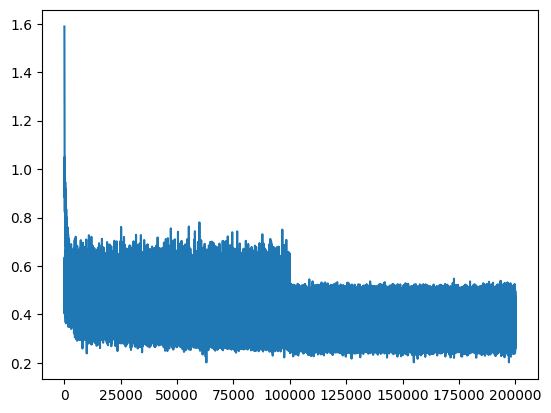

In [93]:
plt.plot(steps, log_loss)

In [98]:
# loss on a whole training set
embedings = C_2[X_train_2] 
hidden_layer = torch.tanh(embedings.view(-1, dim_2 * context_length_2) @ weights1_2 + bias1_2)
logits = hidden_layer @ weights2_2 + bias2_2    
loss = F.cross_entropy(logits, Y_train_2)
loss

tensor(2.4088, grad_fn=<NllLossBackward0>)

In [99]:
# loss on a dev set
embedings = C_2[X_dev_2]             
hidden_layer = torch.tanh(embedings.view(-1, dim_2 * context_length_2) @ weights1_2 + bias1_2)
logits = hidden_layer @ weights2_2 + bias2_2   
loss = F.cross_entropy(logits, Y_dev_2)
loss

tensor(2.4107, grad_fn=<NllLossBackward0>)

batch size: 32 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 10 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 200 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 2.4088 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.4107

##### E02 (2)

In [107]:
# divide into training set (80%), validation/dev set (10%) and test set (10%)
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

context_length_2 = 3
X_train_2, Y_train_2 = build_dataset(words[:n1], context_length_2)
X_dev_2, Y_dev_2 = build_dataset(words[n1:n2], context_length_2)
X_test_2, Y_test_2 = build_dataset(words[n2:], context_length_2)

In [108]:
g = torch.Generator().manual_seed(2147483647)
# dim-dimensional vector space for letters
dim_2 = 10
neuron_num_2 = 200
C_2 = torch.randn((27, dim_2), generator=g)
# first layer that is hidden
weights1_2 = torch.randn((dim_2 * context_length_2, neuron_num_2), generator = g) * 0.01
bias1_2 = torch.randn(neuron_num_2, generator=g) * 0
# output layer
weights2_2 = torch.randn((neuron_num_2, 27), generator = g) * 0.01
bias2_2 = torch.randn(27, generator=g) * 0
# all parametters
parameters_2 = [C_2, weights1_2, bias1_2, weights2_2, bias2_2]
sum(p.nelement() for p in parameters_2)

11897

In [109]:
# turning gradient on
for p in parameters_2:
    p.requires_grad = True

In [110]:
steps_2 = []
log_loss_2 = [] 
for i in range(200000):
    # getting minibatch
    index = torch.randint(0, X_train_2.shape[0], (32,)) 

    # forward pass
    embedings = C_2[X_train_2[index]]              
    hidden_layer = torch.tanh(embedings.view(-1, dim_2 * context_length_2) @ weights1_2 + bias1_2)
    logits = hidden_layer @ weights2_2 + bias2_2    
    loss = F.cross_entropy(logits, Y_train_2[index])

    # backward pass
    for p in parameters_2:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01
    for p in parameters_2:
        p.data -= learning_rate * p.grad

    # track log-loss
    steps.append(i)
    log_loss.append(loss.log10().item())
    
    if i % 10000 == 0:
        print(i, loss.item())

0 3.2940804958343506
10000 2.489837884902954
20000 2.42472767829895
30000 2.143441677093506
40000 2.2274696826934814
50000 2.314236640930176
60000 2.50130558013916
70000 2.083341121673584
80000 2.148120164871216
90000 2.169630527496338
100000 2.243969202041626
110000 2.2006213665008545
120000 2.0382869243621826
130000 1.9574164152145386
140000 2.0832619667053223
150000 1.9629911184310913
160000 1.9121209383010864
170000 1.9568790197372437
180000 2.047024726867676
190000 2.1354575157165527


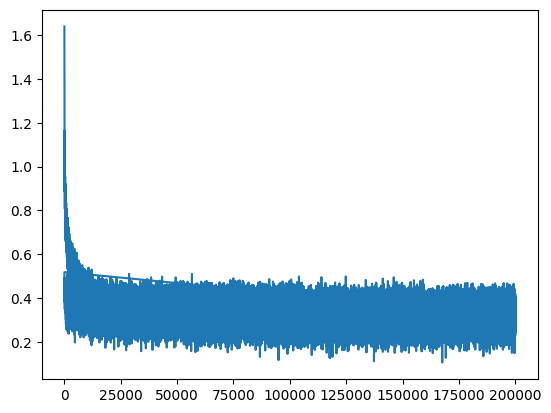

In [111]:
plt.plot(steps, log_loss)

In [112]:
# loss on a whole training set
embedings = C_2[X_train_2] 
hidden_layer = torch.tanh(embedings.view(-1, dim_2 * context_length_2) @ weights1_2 + bias1_2)
logits = hidden_layer @ weights2_2 + bias2_2    
loss = F.cross_entropy(logits, Y_train_2)
loss

tensor(2.1081, grad_fn=<NllLossBackward0>)

In [113]:
# loss on a dev set
embedings = C_2[X_dev_2]             
hidden_layer = torch.tanh(embedings.view(-1, dim_2 * context_length_2) @ weights1_2 + bias1_2)
logits = hidden_layer @ weights2_2 + bias2_2   
loss = F.cross_entropy(logits, Y_dev_2)
loss

tensor(2.1422, grad_fn=<NllLossBackward0>)

batch size: 32 &nbsp;&nbsp;&nbsp;&nbsp; vector dim: 10 &nbsp;&nbsp;&nbsp;&nbsp; num of neurons: 200 &nbsp;&nbsp;&nbsp;&nbsp; train loss: 2.1081 &nbsp;&nbsp;&nbsp;&nbsp; dev loss: 2.1422